# GUMDPs: Policy optimization in the finite trials regime

Notebook containing the experiments for the MountainCar environment.

In [44]:
# A valid Gurobi license is needed (https://www.gurobi.com/).
# GUROBI_OPTIONS = {
#    "WLSACCESSID": ,
#    "WLSSECRET": ,
#    "LICENSEID": ,
#}

In [ ]:
import os
import math
import json
import itertools
import numpy as np
import matplotlib
import cvxpy as cp
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

from envs.envs_gym import get_gym_env, MOUNTAINCAR_D_BETA_CONTINUOUS

import seaborn as sns
sns.set_style("dark")

matplotlib.rcParams['text.usetex'] =  True
plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsfonts}')
matplotlib.rcParams.update({'font.size': 16})

sns.set_palette("colorblind")

#### Auxiliary functions

In [2]:
def sample_trajectory(env, policy, traj_length):
    # Args:
    # env - environment.
    # policy - policy specification (np.array).
    # traj_length - length of the sampled trajectory.

    states = []
    actions = []

    s_discrete, s_continuous = env.reset()

    for t in range(traj_length):
        states.append(s_discrete)

        a = np.random.choice(range(env.num_actions), p=policy[s_discrete])
        actions.append(a)

        s_discrete, _, _, _, s_continuous = env.step(s_continuous, a)

    return states, actions

In [3]:
def estimate_d_pi_from_trajectory(env, trajectory_states, trajectory_actions, gamma):

    nS = env.num_states
    nA = env.num_actions

    d_hats = []
    d_hat = np.zeros((nS,nA))
    for t in range(len(trajectory_states)):
        s_t = trajectory_states[t]
        a_t = trajectory_actions[t]
        
        d_hat[s_t,a_t] += gamma**t * 1

        d_hats.append(((1 - gamma)/(1 - gamma**(t+1))) * d_hat)
        
    return np.array(d_hats)

In [4]:
def estimate_f_d_pi_from_samples(env, obj_f, gamma, policy, N, K, max_traj_length, flatten=False):
    
    nS = env.num_states
    nA = env.num_actions

    f_estimated_list = []
    for n in range(N):

        # Compute d_hat from K sampled trajectories.
        d_hat = np.zeros((max_traj_length,nS,nA))
        for k in range(K):
            traj_states, traj_actions = sample_trajectory(env, policy, traj_length=max_traj_length)
            d_hat += estimate_d_pi_from_trajectory(env, traj_states, traj_actions, gamma)
        d_hat = d_hat / K

        # Compute f(d_hat), d_hat.shape = [max_traj_length, nS, nA].
        if not flatten:
            f_d_hat = np.array([obj_f(x) for x in d_hat])
        else:
            f_d_hat = np.array([obj_f(x.flatten()) for x in d_hat])

        f_estimated_list.append(f_d_hat)

    return np.array(f_estimated_list) # [N, max_traj_length]

In [5]:
def mean_ci(samples: np.ndarray, num_resamples: int=25_000):
    # Point estimation.
    point_estimate = np.mean(samples)
    # Confidence interval estimation.
    resampled = np.random.choice(samples,
                                size=(len(samples), num_resamples),
                                replace=True)
    point_estimations = np.mean(resampled, axis=0)
    confidence_interval = [np.percentile(point_estimations, 5),
                           np.percentile(point_estimations, 95)]
    return confidence_interval

In [6]:
def construct_random_policy(nS, nA):
    pol = np.ones((nS, nA))
    return pol / np.sum(pol, axis=1, keepdims=True)
# print(construct_random_policy(nS=5, nA=3))

#### Infinite trials solver

In [7]:
def build_transition_matrix(env, num_samples=2_000):
    
    nS = env.num_states
    nA = env.num_actions
    P = np.zeros((nA, nS, nS))
    
    for action in range(nA):
        for state in range(nS):

            count_next_states = np.zeros(nS)
            for _ in range(num_samples):
                continuous_state = env._get_continuous_state(state)
                new_state, _, _, _, _  = env.step(continuous_state, action)
                count_next_states[new_state] += 1
            P[action,state,:] = count_next_states / np.sum(count_next_states)

    return P

def build_initial_states_distribution(env, num_samples=2_000):
    
    nS = env.num_states

    count_initial_states = np.zeros(nS)
    for _ in range(num_samples):
        initial_state, _ = env.reset()
        count_initial_states[initial_state] += 1
    p_0 = count_initial_states / np.sum(count_initial_states)

    return p_0
    
# env, obj_f = get_gym_env("pendulum_entropy")
# print("env.num_states", env.num_states)
# print("env.num_actions", env.num_actions)  
# P_sampled = build_transition_matrix(env)

In [8]:
def solve_cvx_opt_problem(env, obj_f, gamma):

    nS = env.num_states
    nA = env.num_actions

    print('Building transition matrix and initial states distribution...')
    P_matrix = build_transition_matrix(env)
    p_0 = build_initial_states_distribution(env)
    print("P_matrix.shape", P_matrix.shape)
    print("p_0.shape", p_0.shape)
    
    x = cp.Variable((nS, nA))
    
    constraints = []
    for s in range(nS):
        lhs = cp.sum(x[s, :])
        rhs = (1 - gamma) * p_0[s] + gamma * sum(
            cp.sum(cp.multiply(P_matrix[a][:, s], x[:, a])) for a in range(nA)
        )
        constraints.append(lhs == rhs)
    constraints.append(x >= 0.0)

    obj = obj_f(x)
    
    prob = cp.Problem(obj, constraints)
    prob.solve()

    # x.value[x.value < 0.0] = 1e-8 # TODO.
    # x.value += 1e-05 # TODO
    
    # print("status:", prob.status)
    # print("optimal value", prob.value)
    # print("optimal var", x.value)

    opt_policy = x.value / np.sum(x.value, axis=1, keepdims=True)

    return prob.value, opt_policy

#### Plotting functions

In [9]:
def plot_2(DATA_TO_PLOT, mdp_name):

    plt.figure(figsize=(5.0, 4.0))
    
    # Plot f(\hat{d}) of \pi_random.
    random_policy_f_data = DATA_TO_PLOT["random_policy_f"][:,-1]
    cis = mean_ci(random_policy_f_data)
    errors = np.array([np.mean(random_policy_f_data) - cis[0], cis[1] - np.mean(random_policy_f_data)]).reshape(-1,1)
    plt.errorbar(1, np.mean(random_policy_f_data), yerr=errors, capsize=3, fmt='o')

    print("pi_rand", np.mean(random_policy_f_data), "ci_low:", np.mean(random_policy_f_data) - cis[0], "ci_up:", cis[1] - np.mean(random_policy_f_data))

    # Plot f(\hat{d}) of \pi_\infty^*.
    infinite_trials_policy_f_data = DATA_TO_PLOT["infinite_trials_f"][:,-1]
    cis = mean_ci(infinite_trials_policy_f_data)
    errors = np.array([np.mean(infinite_trials_policy_f_data) - cis[0], cis[1] - np.mean(infinite_trials_policy_f_data)]).reshape(-1,1)
    plt.errorbar(2, np.mean(infinite_trials_policy_f_data), yerr=errors, capsize=3, fmt='o')

    print("pi_infinity", np.mean(infinite_trials_policy_f_data), "ci_low:", np.mean(infinite_trials_policy_f_data) - cis[0], "ci_up:", cis[1] - np.mean(infinite_trials_policy_f_data))
    
    # Plot f(\hat{d}) of MCTS policy.
    mcts_data = DATA_TO_PLOT["mcts_planner"]
    cis = mean_ci(mcts_data)
    errors = np.array([round(np.mean(mcts_data) - cis[0],4), round(cis[1] - np.mean(mcts_data),4)]).reshape(-1,1)
    plt.errorbar(3, np.mean(mcts_data), yerr=errors, capsize=3, fmt='o')

    print("pi_mcts", np.mean(mcts_data), "ci_low:", np.mean(mcts_data) - cis[0], "ci_up:", cis[1] - np.mean(mcts_data))
    
    # ax.set_ylim([-1.5,-0.2])
    plt.xticks([1,2,3], [r"$\pi = \pi_{Random}$", r"$\pi = \pi_\infty^*$", r"$\pi = \pi^*_{MCTS}$"])
    plt.grid()
    #plt.legend()

    plt.ylabel(r'$F_{1,H}(\pi)$')

    os.makedirs("figs/", exist_ok=True)
    plt.savefig(f'figs/{mdp_name}_plot2.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

In [10]:
def plot_3(DATA_TO_PLOT, mdp_name):

    plt.figure(figsize=(5.0, 4.0))
    # fig.tight_layout()
    
    # Plot f(\hat{d}) of \pi_random.
    random_policy_f_data = DATA_TO_PLOT["random_policy_f"][:,-1]
    plt.violinplot(random_policy_f_data, [1], widths=0.3,
                       showmeans=False, showmedians=True, showextrema=True)
    
    # Plot f(\hat{d}) of \pi_\infty^*.
    infinite_trials_policy_f_data = DATA_TO_PLOT["infinite_trials_f"][:,-1]
    plt.violinplot(infinite_trials_policy_f_data, [2], widths=0.3,
                      showmeans=False, showmedians=True, showextrema=True)

    # Plot f(\hat{d}) of MCTS policy.
    mcts_data = DATA_TO_PLOT["mcts_planner"]
    plt.violinplot(mcts_data, [3], widths=0.3,
                       showmeans=False, showmedians=True, showextrema=True)
    
    #ax.set_ylim([-0.01,1.01])
    # ax.set_title(r"$\gamma = $ " + str(gamma_val))
    #ax.set_xlabel(r'$H$')

    plt.grid()
    #ax.legend()
    plt.xticks([1,2,3], [r"$\pi = \pi_{Random}$", r"$\pi = \pi_\infty^*$", r"$\pi = \pi^*_{MCTS}$"])

    plt.ylabel(r'$F_{1,H}(\pi)$')
    
    os.makedirs("figs/", exist_ok=True)
    plt.savefig(f'figs/{mdp_name}_plot3.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

## Imitation learning

#### The objective function is $f(d) = \| d - d_\beta\|_2^2, \quad d_\beta \in \Delta(\mathcal{S} \times \mathcal{A})$

#### Mountaincar environment (continuous)

In [11]:
def compute_random_policy_objective_imitation_learning(env, obj_f, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = mcts_plan_data["config"]["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)

    # Compute random policy finite trials objective value.
    random_policy = construct_random_policy(nS=env.num_states, nA=env.num_actions)
    random_policy_f_estimated = estimate_f_d_pi_from_samples(env, obj_f, gamma, random_policy,
                                                             N=N, K=K, max_traj_length=max_traj_length, flatten=False)

    return np.array(random_policy_f_estimated) # [N,H]

In [12]:
def load_mcts_data_imitation_learning(mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    return np.array(mcts_plan_data["f_vals"]) # [N]

In [13]:
import gurobipy as gp
from gurobipy import GRB

def solve_gurobi_opt_problem_imitation_learning(env, gamma, d_beta):

    nS = env.num_states
    nA = env.num_actions

    print('Building transition matrix and initial states distribution...')
    P_matrix = build_transition_matrix(env)
    p_0 = build_initial_states_distribution(env)
    print("P_matrix.shape", P_matrix.shape)
    print("p_0.shape", p_0.shape)
    
    with gp.Env(params=GUROBI_OPTIONS) as guroby_env, gp.Model(env=guroby_env) as m:
    
        x = m.addVars(nS, nA, lb=0.0, name="x")
    
        for s in range(nS):
            lhs = gp.quicksum(x[s, a] for a in range(nA))
            
            rhs = (1 - gamma) * p_0[s]
            
            for a in range(nA):
                rhs += gamma * gp.quicksum(P_matrix[a][s_prime, s] * x[s_prime, a] for s_prime in range(nS))
            
            m.addConstr(lhs == rhs, name=f"flow_state_{s}")
    
        quad_expr = gp.QuadExpr()
        for s in range(nS):
            for a in range(nA):
                quad_expr.add(x[s, a] * x[s, a] - 2 * d_beta[s, a] * x[s, a])    
            
        # Set the objective. Change GRB.MAXIMIZE to GRB.MINIMIZE if needed.
        m.setObjective(quad_expr, GRB.MINIMIZE)
        
        m.optimize()

        # Check if the optimization succeeded.
        if m.status != GRB.OPTIMAL:
            raise Exception("Model did not solve optimally.")
    
        # Extract the solution.
        x_opt = np.zeros((nS, nA))
        for s in range(nS):
            for a in range(nA):
                x_opt[s, a] = x[s, a].X

        obj_val = m.ObjVal

    opt_policy = x_opt / np.sum(x_opt, axis=1, keepdims=True)

    # row_sum = np.sum(x_opt, axis=1, keepdims=True)
    # opt_policy = np.divide(x_opt, row_sum, out=np.zeros_like(x_opt), where=row_sum != 0)
    
    return obj_val, opt_policy

In [14]:
def compute_infinite_trials_objective_imitation_learning(env, obj_f, d_beta, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = mcts_plan_data["config"]["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)
    
    x_star, opt_policy_infinite_trials = solve_gurobi_opt_problem_imitation_learning(env, gamma, d_beta)
    # print("np.sum(opt_policy_infinite_trials)", np.sum(opt_policy_infinite_trials))
    # print("opt_policy_infinite_trials[np.where(opt_policy_infinite_trials < 0.0)]", opt_policy_infinite_trials[np.where(opt_policy_infinite_trials < 0.0)])
    infinite_trials_f_estimated = estimate_f_d_pi_from_samples(env, obj_f, gamma, opt_policy_infinite_trials,
                                                            N=N, K=K, max_traj_length=max_traj_length, flatten=False)

    return np.array(infinite_trials_f_estimated) # [N,H]

In [ ]:
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]
mcts_planner_data = ['mountain_car_continuous_imitation_learning_mcts_gamma_0.9_2025-04-29-22-35-07', 'mountain_car_continuous_imitation_learning_mcts_gamma_0.9_2025-04-29-22-35-17', 'mountain_car_continuous_imitation_learning_mcts_gamma_0.9_2025-04-29-22-35-39', 'mountain_car_continuous_imitation_learning_mcts_gamma_0.9_2025-04-29-22-36-46', 'mountain_car_continuous_imitation_learning_mcts_gamma_0.9_2025-04-29-22-39-02', 'mountain_car_continuous_imitation_learning_mcts_gamma_0.9_2025-04-29-22-53-49', 'mountain_car_continuous_imitation_learning_mcts_gamma_0.9_2025-04-29-23-25-18', 'mountain_car_continuous_imitation_learning_mcts_gamma_0.9_2025-04-30-00-33-07', 'mountain_car_continuous_imitation_learning_mcts_gamma_0.9_2025-04-29-16-56-22']

env, obj_f = get_gym_env("mountain_car_continuous_imitation_learning")

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]

# Load distribution to imitate.
with open("data/" + MOUNTAINCAR_D_BETA_CONTINUOUS + "/train_data.json", 'r') as f:
    ql_data = json.load(f)
    ql_data = json.loads(ql_data)
f.close()
imitation_learning_d_beta = np.array(ql_data["estimated_d_pi"])

data_to_plot = {}
data_to_plot["random_policy_f"] = compute_random_policy_objective_imitation_learning(env, obj_f, mcts_data_path)
data_to_plot["mcts_planner"] = load_mcts_data_imitation_learning(mcts_data_path)
data_to_plot["infinite_trials_f"] = compute_infinite_trials_objective_imitation_learning(env, obj_f, imitation_learning_d_beta, mcts_data_path)
# print(data_to_plot)
print("Random policy:", data_to_plot["random_policy_f"][:,-1])
print("Infinite trials policy:", data_to_plot["infinite_trials_f"][:,-1])
print("MCTS planner:", data_to_plot["mcts_planner"])

pi_rand 0.1786984098215929 ci_low: 0.03889044802619229 ci_up: 0.040853116355808405
pi_infinity 0.06538797344293193 ci_low: 0.013572382653567222 ci_up: 0.015756554043875173
pi_mcts 0.035875588806530835 ci_low: 0.010988176762198085 ci_up: 0.012558103163929565


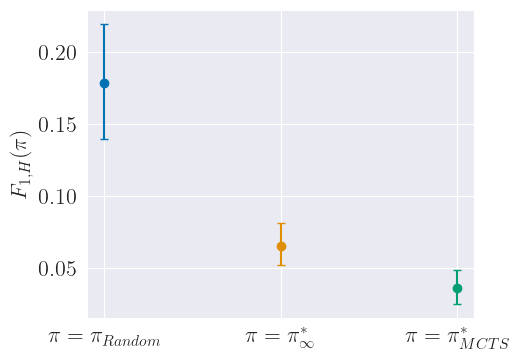

In [23]:
plot_2(data_to_plot, mdp_name=f"mountaincar_continuous_env_imitation_learning_exp_steps_{exp_steps[exp_idx_to_plot]}")

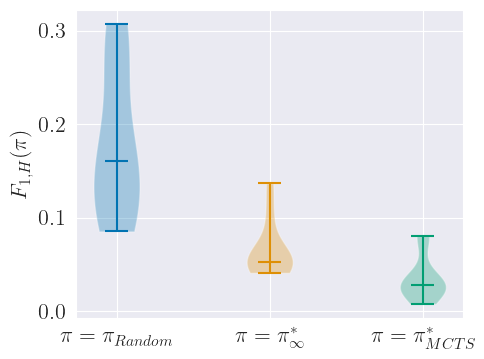

In [24]:
plot_3(data_to_plot, mdp_name=f"mountaincar_continuous_env_imitation_learning_exp_steps_{exp_steps[exp_idx_to_plot]}")

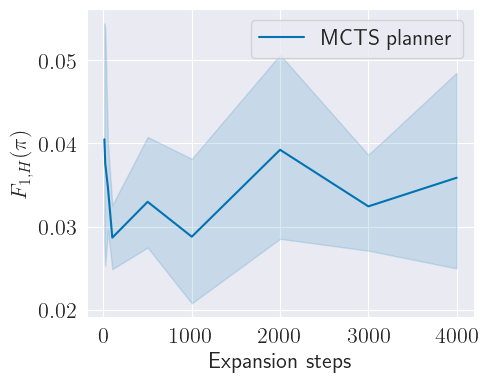

In [25]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data_imitation_learning(mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/mountaincar_continuous_imitation_learning.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Entropy maximization

In [30]:
def load_mcts_data_entropy(env, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    return np.array(mcts_plan_data["f_vals"]) # [N]

In [31]:
def compute_random_policy_objective_entropy(env, obj_f, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = mcts_plan_data["config"]["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)

    # Compute random policy finite trials objective value.
    random_policy = construct_random_policy(nS=env.num_states, nA=env.num_actions)
    random_policy_f_estimated = estimate_f_d_pi_from_samples(env, obj_f, gamma, random_policy,
                                                             N=N, K=K, max_traj_length=max_traj_length, flatten=True)

    return np.array(random_policy_f_estimated) # [N,H]

In [32]:
def solve_cvx_opt_problem(env, obj_f, gamma):

    nS = env.num_states
    nA = env.num_actions

    print('Building transition matrix and initial states distribution...')
    P_matrix = build_transition_matrix(env)
    p_0 = build_initial_states_distribution(env)
    print("P_matrix.shape", P_matrix.shape)
    print("p_0.shape", p_0.shape)
    
    x = cp.Variable((nS, nA))
    
    constraints = []
    for s in range(nS):
        lhs = cp.sum(x[s, :])
        rhs = (1 - gamma) * p_0[s] + gamma * sum(
            cp.sum(cp.multiply(P_matrix[a][:, s], x[:, a])) for a in range(nA)
        )
        constraints.append(lhs == rhs)
    constraints.append(x >= 0.0)

    obj = obj_f(x)
    
    prob = cp.Problem(obj, constraints)
    prob.solve()

    # x.value[x.value < 0.0] = 1e-8 # TODO.
    # x.value += 1e-05 # TODO
    
    # print("status:", prob.status)
    # print("optimal value", prob.value)
    # print("optimal var", x.value)

    opt_policy = x.value / np.sum(x.value, axis=1, keepdims=True)

    return prob.value, opt_policy

In [33]:
def compute_infinite_trials_objective_entropy(env, obj_f, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = mcts_plan_data["config"]["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)
    
    # Define objective function.
    cvx_obj_f = lambda x: cp.Minimize(-cp.sum(cp.entr(x))) # (Minus) entropy function.
    x_star, opt_policy_infinite_trials = solve_cvx_opt_problem(env, cvx_obj_f, gamma)
    # print("np.sum(opt_policy_infinite_trials)", np.sum(opt_policy_infinite_trials))
    # print("opt_policy_infinite_trials[np.where(opt_policy_infinite_trials < 0.0)]", opt_policy_infinite_trials[np.where(opt_policy_infinite_trials < 0.0)])
    infinite_trials_f_estimated = estimate_f_d_pi_from_samples(env, obj_f, gamma, opt_policy_infinite_trials,
                                                            N=N, K=K, max_traj_length=max_traj_length, flatten=True)

    return np.array(infinite_trials_f_estimated) # [N,H]

In [40]:
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]
mcts_planner_data = ['mountain_car_continuous_entropy_mcts_gamma_0.9_2025-04-29-22-37-26', 'mountain_car_continuous_entropy_mcts_gamma_0.9_2025-04-29-22-37-39', 'mountain_car_continuous_entropy_mcts_gamma_0.9_2025-04-29-22-38-06', 'mountain_car_continuous_entropy_mcts_gamma_0.9_2025-04-29-22-39-19', 'mountain_car_continuous_entropy_mcts_gamma_0.9_2025-04-29-22-42-08', 'mountain_car_continuous_entropy_mcts_gamma_0.9_2025-04-29-22-58-49', 'mountain_car_continuous_entropy_mcts_gamma_0.9_2025-04-29-23-34-47', 'mountain_car_continuous_entropy_mcts_gamma_0.9_2025-04-30-00-48-58', 'mountain_car_continuous_entropy_mcts_gamma_0.9_2025-04-30-02-46-31']

env, obj_f = get_gym_env("mountain_car_continuous_entropy")

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]
data_to_plot = {}
data_to_plot["random_policy_f"] = compute_random_policy_objective_entropy(env, obj_f, mcts_data_path)
data_to_plot["mcts_planner"] = load_mcts_data_entropy(env, mcts_data_path)
data_to_plot["infinite_trials_f"] = compute_infinite_trials_objective_entropy(env, obj_f, mcts_data_path)
# print(data_to_plot)
print("Random policy:", data_to_plot["random_policy_f"][:,-1])
print("Infinite trials policy:", data_to_plot["infinite_trials_f"][:,-1])
print("MCTS planner:", data_to_plot["mcts_planner"])

N 10
Max. traj. length: 200
Gamma: 0.9
N 10
Max. traj. length: 200
Gamma: 0.9
Building transition matrix and initial states distribution...
P_matrix.shape (3, 100, 100)
p_0.shape (100,)
Random policy: [0.77763647 0.75443395 0.69331767 0.69554891 0.72219439 0.6826802
 0.6762019  0.77722562 0.65222852 0.75100382]
Infinite trials policy: [0.61014348 0.68323027 0.7284172  0.70757416 0.78225593 0.67394812
 0.76663131 0.62499967 0.65034984 0.75721828]
MCTS planner: [0.5915997  0.63689355 0.63697344 0.63873943 0.55242298 0.58892935
 0.63686235 0.6318645  0.57784154 0.63927744]


pi_rand 0.7182471427717412 ci_low: 0.02203782465601578 ci_up: 0.021996276976258722
pi_infinity 0.6984768255098983 ci_low: 0.029422526259788917 ci_up: 0.029868507709653103
pi_mcts 0.6131404280777936 ci_low: 0.016455718321834234 ci_up: 0.01492077311101403


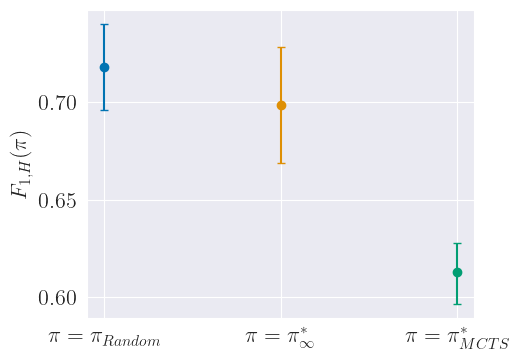

In [41]:
plot_2(data_to_plot, mdp_name=f"mountaincar_continuous_env_entropy_exp_steps_{exp_steps[exp_idx_to_plot]}")

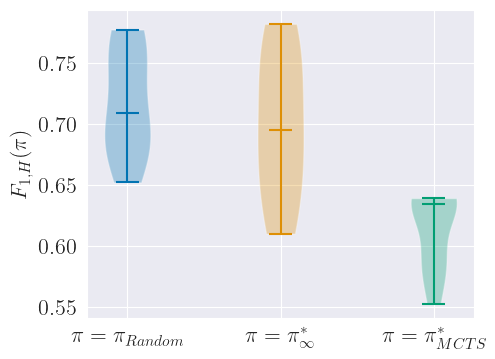

In [42]:
plot_3(data_to_plot, mdp_name=f"mountaincar_continuous_env_entropy_exp_steps_{exp_steps[exp_idx_to_plot]}")

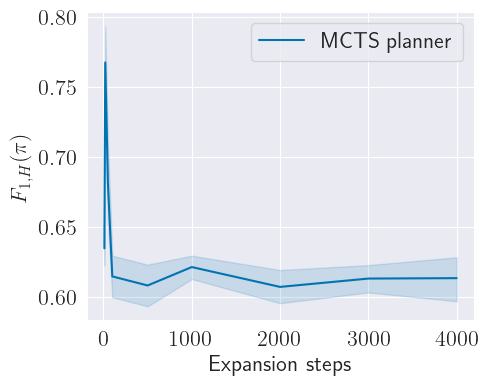

In [43]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data_entropy(env, mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/mountaincar_continuous_entropy.pdf', bbox_inches='tight', pad_inches=0)
plt.show()